In [1]:
import pandas as pd

from rmexp import schema
from rmexp.utilityfunc import app_default_utility_func


In [20]:
df = pd.read_sql("select * from ExpLatency", schema.engine).drop(['id', 'date'], axis=1)
df['per_frame_util'] = df.apply(
    lambda r: app_default_utility_func[r['app']](r['reply']),
    axis=1
)
df['index_int'] = df['index'].astype(int)
df.head(5)

,name,index,val,app,client,arrival,finished,reply,per_frame_util,index_int
0,face4-baseline,0,None,face,1,12,199,200,1.000000,0
1,face4-baseline,0,None,face,0,5,216,217,1.000000,0
2,face4-baseline,1,None,face,0,199,379,380,1.000000,1
3,face4-baseline,0,None,face,2,194,371,372,1.000000,0
4,face4-baseline,1,None,face,2,366,547,548,0.999363,1


In [21]:
util_summary = df.groupby(['name', 'app']).agg('mean')
util_summary.head(30)

arrival     finished  \
name                                 app                                  
face1-baseline                       face        15.323232   267.668687   
face1-greedyratio                    face       309.387625   572.634213   
face1pool1-baseline                  face        15.558767   265.290944   
                                     pool        67.234513   190.508850   
face1pool1-greedyratio               face       476.810585   717.286908   
                                     pool      2519.029126  2656.252427   
face1pool1pingpong1-baseline         face        14.426386   267.833652   
                                     pingpong    14.137961    60.322194   
                                     pool       125.593548   307.058065   
face1pool1pingpong1-greedyratio      face       457.715847   693.177596   
                                     pool      2470.809524  2605.347619   
face1pool1pingpong1lego1-baseline    face        13.486922   283.267606   
                                     lego        12.889556    99.309724   
                                     pingpong    13.489300    83.534047   
                                     pool       205.324074   466.546296   
face1pool1pingpong1lego1-greedyratio lego       358.703283   441.441919   
                                     pool      1945.116105  2049.921348   
face4-baseline                       face       555.688836   768.001188   
face4-greedyratio                    face       375.877771   598.158961   
face4pool4-baseline                  face       584.681592   806.195274   
                                     pool       572.137715   711.161189   
face4pool4-greedyratio               face       147.425505   369.362374   
                                     pool      1941.639241  2081.088608   
face4pool4pingpong4-baseline         face       706.108664   966.327460   
                                     pingpong   408.753236   558.411562   
                                     pool      1438.659236  1717.754777   
face4pool4pingpong4-greedyratio      face       140.821473   359.626717   
                                     pool      2168.242472  2307.835182   
face4pool4pingpong4lego4-baseline    face      1226.227941  1658.698529   
                                     lego       859.295533  1157.908935   

                                                     reply  per_frame_util  \
name                                 app                                     
face1-baseline                       face       275.432323    9.997664e-01   
face1-greedyratio                    face       779.764331    7.984465e-01   
face1pool1-baseline                  face       271.522158    9.999538e-01   
                                     pool       193.336283    3.384287e-02   
face1pool1-greedyratio               face       756.621170    8.491236e-01   
                                     pool      2669.577670    9.519867e-74   
face1pool1pingpong1-baseline         face       272.313576    9.999316e-01   
                                     pingpong    83.274207    9.951330e-01   
                                     pool       309.451613    3.991501e-06   
face1pool1pingpong1-greedyratio      face       738.620219    8.575774e-01   
                                     pool      2621.700000    1.882435e-72   
face1pool1pingpong1lego1-baseline    face       288.102616    9.995141e-01   
                                     lego       133.575030    9.999943e-01   
                                     pingpong   102.400778    9.475741e-01   
                                     pool       468.629630    2.352723e-11   
face1pool1pingpong1lego1-greedyratio lego       616.810606    9.883960e-01   
                                     pool      2069.468165    6.756865e-80   
face4-baseline                       face       769.927553    9.007524e-01   
face4-greedyratio                    face       604.262191    9.701936e-01   
face4pool4-b

In [22]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)

In [23]:
baseline_total_utilities = []
ours_total_utilities = []
experiments = ['face1', 'face1pool1', 'face1pool1pingpong1', 'face1pool1pingpong1lego1']
apps = ['lego', 'pingpong', 'face', 'pool']

BASELINE = 0
OURS = 1

utilities = {
    app: {
        experiment: [0, 0]
        for experiment in experiments
    }
    for app in apps
}

for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-greedyratio'.format(experiment)]
    
    baseline_total_utility = 0
    ours_total_utility = 0
    
    for app in apps:
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]
    
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)

            valid_baseline_app_df = baseline_app_df[baseline_app_df.index_int < max_index_app]
            valid_ours_app_df = ours_app_df[ours_app_df.index_int < max_index_app]

            baseline_app_utility = valid_baseline_app_df.per_frame_util.sum()
            ours_app_utility = valid_ours_app_df.per_frame_util.sum()
        else:
            baseline_app_utility = 0
            ours_app_utility = 0
    
        utilities[app][experiment][BASELINE] = baseline_app_utility
        utilities[app][experiment][OURS] = ours_app_utility
        
        baseline_total_utility += baseline_app_utility
        ours_total_utility += ours_app_utility
    
    baseline_total_utilities.append(baseline_total_utility)
    ours_total_utilities.append(ours_total_utility)

<IPython.core.display.Javascript object>


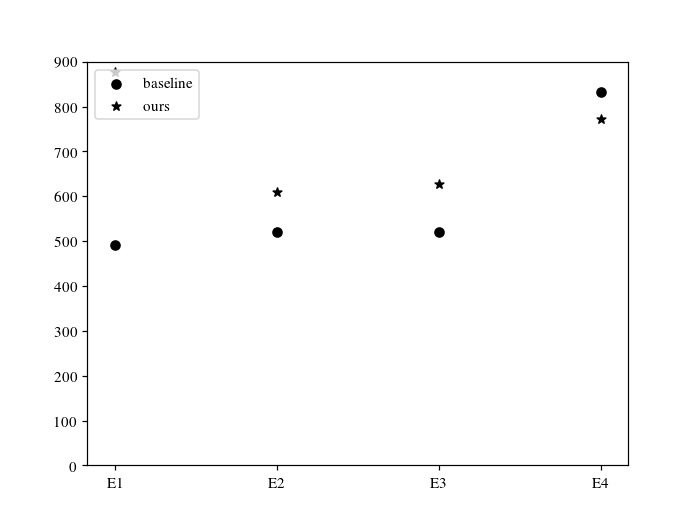

[491.88434919415533, 521.1992723227833, 520.9648328671641, 831.9952228752245]
[876.4932754017382, 608.6732702536549, 626.7468430894261, 772.0452229645638]


In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

AXIS_TITLES = ['E1', 'E2', 'E3', 'E4']

print(baseline_total_utilities)
print(ours_total_utilities)
ax1.scatter(AXIS_TITLES, baseline_total_utilities, color='k', marker='o', label='baseline')
ax1.scatter(AXIS_TITLES, ours_total_utilities, color='k', marker='*', label='ours')
ax1.set_ylim(ymin=0)
plt.legend(loc='upper left')
plt.show()
plt.savefig('total-utilities.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


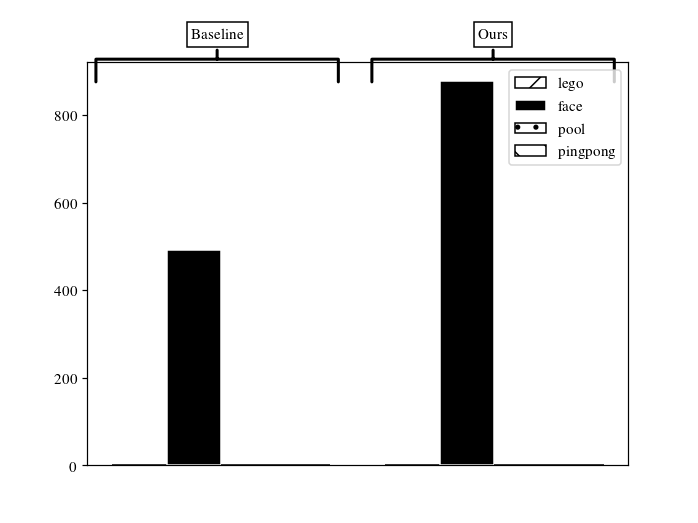

<IPython.core.display.Javascript object>


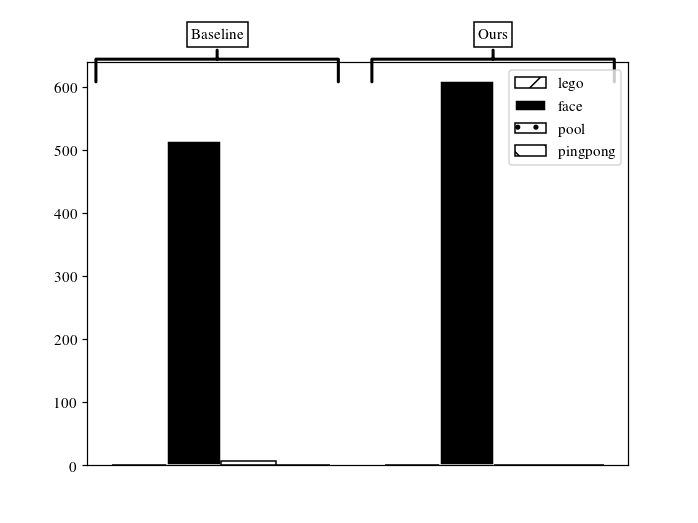

<IPython.core.display.Javascript object>


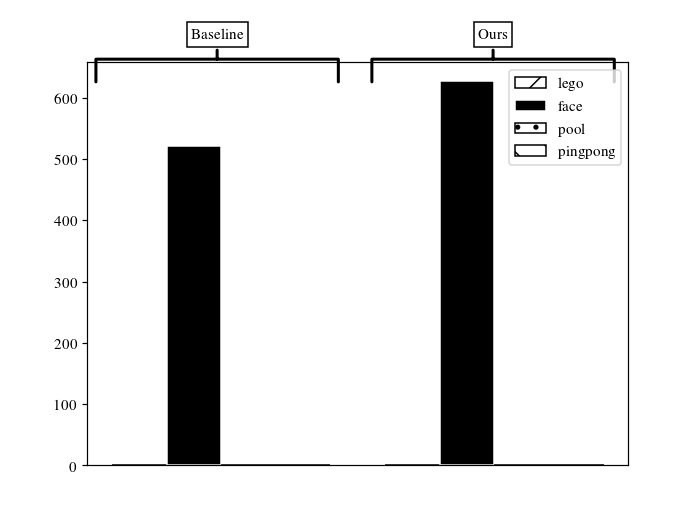

<IPython.core.display.Javascript object>


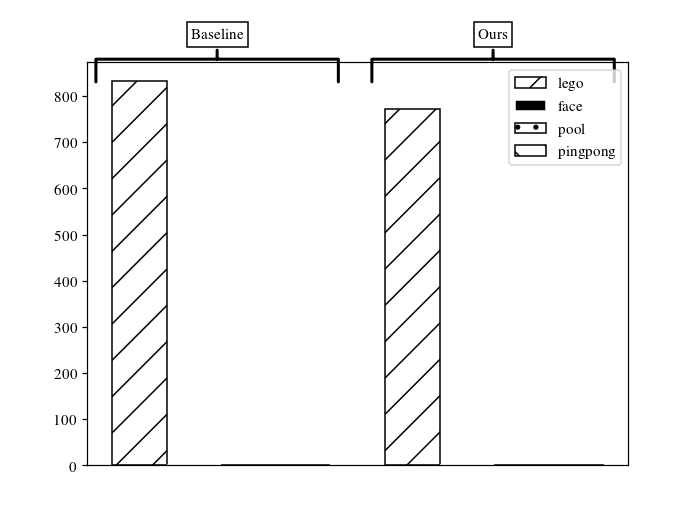

In [25]:
for experiment in experiments:
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.bar([0, 1], utilities['lego'][experiment], width=0.2, color='w', edgecolor='k', hatch='/', align='center', label='lego')
    ax.bar([0.2, 1.2], utilities['face'][experiment], width=0.2, color='k', edgecolor='w', align='center', label='face')
    ax.bar([0.4, 1.4], utilities['pool'][experiment], width=0.2, color='w', edgecolor='k', hatch='.', align='center', label='pool')
    ax.bar([0.6, 1.6], utilities['pingpong'][experiment], width=0.2, color='w', edgecolor='k', hatch='\\', align='center', label='pingpong')
    
    # https://stackoverflow.com/a/35322778/859277
    ax.annotate('Baseline', xy=(0.24, 1.00), xytext=(0.24, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.annotate('Ours', xy=(0.75, 1.00), xytext=(0.75, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.axes.get_xaxis().set_visible(False)

    plt.legend()
    plt.show()
    plt.savefig('utility-{}.pdf'.format(experiment), bbox_inches='tight')

In [182]:
df.loc[df['app'] == 'pool'].per_frame_util.sum()

188.41249037027762

In [161]:
df.loc[(df['name'] == 'lego1pingpong1face1-ours') & (df['app'] == 'lego')].per_frame_util.sum()

1075.4949020380327

In [177]:
for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-ours'.format(experiment)]    
    for app in apps:
        proccessed_baseline = 0
        skipped_baseline = 0        
        
        proccessed_ours = 0
        skipped_ours = 0
        
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]        
        
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)
            
            max_index_baseline_app_index_values = baseline_app_df.index_int.values
            max_index_ours_app_index_values = ours_app_df.index_int.values

            for i in xrange(max_index_app):
                if i in max_index_baseline_app_index_values:
                    proccessed_baseline += 1
                else:
                    skipped_baseline += 1
                    
                if i in max_index_ours_app_index_values:
                    proccessed_ours += 1
                else:
                    skipped_ours += 1
            print experiment, app, 'baseline'
            print 'processed:', proccessed_baseline, 'skipped:', skipped_baseline
            print ''
            print experiment, app, 'ours'
            print 'processed:', proccessed_ours, 'skipped:', skipped_ours
            print ''

lego2 lego baseline
processed: 1279 skipped: 1419

lego2 lego ours
processed: 1331 skipped: 1367

lego2face2 lego baseline
processed: 977 skipped: 1719

lego2face2 lego ours
processed: 1079 skipped: 1617

lego2face2 face baseline
processed: 794 skipped: 1897

lego2face2 face ours
processed: 739 skipped: 1952

lego2face2pool2 lego baseline
processed: 681 skipped: 2008

lego2face2pool2 lego ours
processed: 959 skipped: 1730

lego2face2pool2 face baseline
processed: 518 skipped: 2171

lego2face2pool2 face ours
processed: 687 skipped: 2002

lego2face2pool2 pool baseline
processed: 367 skipped: 2082

lego2face2pool2 pool ours
processed: 24 skipped: 2425

lego2pingpong2face2pool2 lego baseline
processed: 507 skipped: 2185

lego2pingpong2face2pool2 lego ours
processed: 1181 skipped: 1511

lego2pingpong2face2pool2 pingpong baseline
processed: 376 skipped: 2274

lego2pingpong2face2pool2 pingpong ours
processed: 719 skipped: 1931

lego2pingpong2face2pool2 pool baseline
processed: 257 skipped: 19

In [183]:
utilities['pool']['lego2pingpong2face2pool2']

[2.3109513872765699e-21, 0.0]